In [1]:
%load_ext autoreload
%autoreload 2


import torch
from torch import nn
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
from torchvision.models import ViT_L_16_Weights, vit_l_16
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm.auto import tqdm

from drecg.data.utils import list_file_pairs, validate_file_pair, ImagePairDataset, preview_image_data
from drecg.models.baseline import FeatureExtractorConv2d, Detector

test_same, test_diff = list(list_file_pairs(part='same', root='/home/daniel/data_dogs/testing')), list(list_file_pairs(part='different', root='/home/daniel/data_dogs/testing'))
train_same, train_diff = list(list_file_pairs(part='same', root='/home/daniel/data_dogs/training')), list(list_file_pairs(part='different', root='/home/daniel/data_dogs/training'))

#### Vit Model Verification
* Verify the model works with the pretrained weights for dog classification
* Prepare a Batch of Images
* Load the Pretrained Model (create function)
* Execute prediction
* Load the label descriptions
* Display the results with images and labels

In [2]:
from torchvision.transforms.functional import to_pil_image

transform = ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()   
images_to_use = train_same[20:23]
dataset = ImagePairDataset(images_to_use, transforms=transform, label=1)
device = torch.device('cuda')

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
denorm = Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1.0 / s for s in std],
)

def create_vit_feat_ext(remove_head=True):
    vit_model = vit_l_16(weights=ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1)
    if remove_head:
        vit_model.heads = nn.Identity()
    return vit_model

dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
dataloader_iter = iter(dataloader)
batch = next(dataloader_iter)

def tranformed_to_pil(transformed):
    return to_pil_image((denorm(transformed)*255).to(torch.uint8))

In [3]:

ds_same = ImagePairDataset(train_same, transforms=transform, label=1)
ds_diff = ImagePairDataset(train_diff, transforms=transform, label=0)
ds = ds_same + ds_diff
dl_full = DataLoader(ds, batch_size=16, shuffle=True, num_workers=8)

ds_test_same = ImagePairDataset(test_same, transforms=transform, label=1)
ds_test_diff = ImagePairDataset(test_diff, transforms=transform, label=0)
ds_test = ds_test_same + ds_test_diff
dl_test = DataLoader(ds_test, batch_size=16, shuffle=False, num_workers=8)

In [5]:
from drecg.models.baseline import LFullModel
vit_extractor = create_vit_feat_ext(remove_head=True)
f_extractor = lambda: vit_extractor

model_det = Detector(feature_extractor=f_extractor, features_dim=1024, hidden_dim=256, train_extractor=False)
model = LFullModel(model_det)

In [6]:
from drecg.training.loops import train_full, train_lightning
trainer = train_lightning(model, dl_full, dl_test, epochs=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Detector          | 524 K 
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | valid_acc | Accuracy          | 0     
------------------------------------------------
304 M     Trainable params
0         Non-trainable params
304 M     Total params
1,218.697 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


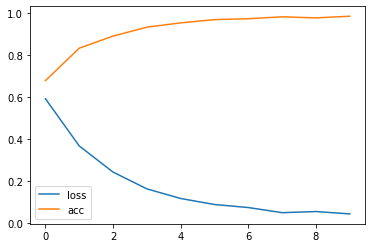

In [16]:
hist_loss, hist_acc = Out[5]
#Plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(hist_loss)
plt.plot(hist_acc)
plt.legend(['loss', 'acc'])
plt.show()

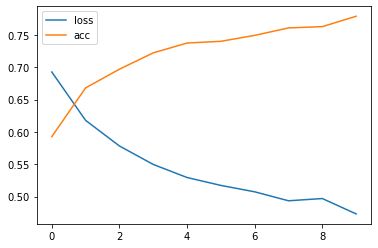

In [7]:
import matplotlib.pyplot as plt
plt.plot(hist_loss)
plt.plot(hist_acc)
plt.legend(['loss', 'acc'])
plt.show()

In [26]:

test_dataset_same = ImagePairDataset(test_same, transforms=transform, label=1)
test_dataset_diff = ImagePairDataset(test_diff, transforms=transform, label=0)

test_dataloader_same = DataLoader(test_dataset_same, batch_size=8, shuffle=True, num_workers=4)
test_dataloader_diff = DataLoader(test_dataset_diff, batch_size=8, shuffle=True, num_workers=4)
test_batch_same_iter = iter(test_dataloader_same)
test_batch_diff_iter = iter(test_dataloader_diff)

In [41]:
test_dataset = test_dataset_same + test_dataset_diff
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [52]:
len(test_dataset)

398

In [29]:


def try_model(model):
    device = torch.device('cuda')
    model.to(device)
    test_batch_same = next(test_batch_same_iter)
    test_batch_diff = next(test_batch_diff_iter)
    batch_img_a = test_batch_same[0][1].to(device)
    batch_img_b = test_batch_same[0][0].to(device)

    batch_diff_img_a = test_batch_diff[0][1].to(device)
    batch_diff_img_b = test_batch_diff[0][0].to(device)

    model.eval()
    with torch.no_grad():
        y_same = model((batch_img_a, batch_img_b))
        y_diff = model((batch_diff_img_a, batch_diff_img_b))

    return torch.round(torch.sigmoid(y_same)), torch.round(torch.sigmoid(y_diff))

In [38]:
try_model(model_v1)

(tensor([[0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.]], device='cuda:0'),
 tensor([[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

In [50]:
from tqdm.auto import tqdm

bar = tqdm(range(len(test_dataloader)))

model.to(device)
model.eval()
correct = 0
count = 0
for (img_a, img_b), label in test_dataloader:
    img_a = img_a.to(device)
    img_b = img_b.to(device)
    label = label.to(device)
    count += label.size(0)
    y_logits = model((img_a, img_b))
    y = torch.round(torch.sigmoid(y_logits)).reshape(-1).to(torch.int)
    label = label.to(torch.int)
    correct += (y == label).sum().item()
    bar.update(1)

  0%|          | 0/13 [00:00<?, ?it/s]

In [54]:
correct/count

0.7638190954773869

In [39]:
torch.save(model_v1, 'saved_models/model_v1.pt')

In [2]:
import torch
save_model = torch.load('saved_models/model_v1_073.pt')

In [6]:
label_desc = ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1.meta['categories']

In [24]:
vit_model.train()
# with torch.no_grad():
out = vit_model(img_batch.to(device))
# out2 = vit_model(img_batch.to(device))

In [5]:
# del out, out2
# del model
torch.cuda.empty_cache()

In [25]:
preds = torch.argmax(out, dim=1)
#convert to labels
[label_desc[pred] for pred in preds]

['toy poodle', 'Blenheim spaniel', 'toy poodle']